## EasyVisa: Problem Statement

### Businees Context

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

### Objective
In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having a higher chance of VISA approval. OFLC has hired the firm EasyVisa for data-driven solutions. You, as a data scientist at EasyVisa, have to analyze the data provided and, with the help of a classification model:

1. Facilitate the process of visa approvals.
2. Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.



### Importing necessary libraries

In [1]:
# This will help in making the Python code more structured automatically (good coding practice)
# %load_ext nb_black

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer
from sklearn import metrics

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

### Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
visa = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EasyVisa.csv")

Mounted at /content/drive


In [3]:
# Checking the number of rows and columns in the data
visa.shape

(25480, 12)

* The dataset has 25480 rows and 12 columns

## Data Overview

**Features Overview:**

**case_id**: Unique identifier for each application (string).

**continent**: Continent of the applicant (categorical).

**education_of_employee**: Education level of the applicant (categorical).

**has_job_experience**: Whether the applicant has job experience (Y/N).

**requires_job_training**: Whether the applicant requires job training (Y/N).

**no_of_employees**: Number of employees in the applying company (integer).

**yr_of_estab**: Year of establishment of the company (integer).

**region_of_employment**: Region where the job is located (categorical).

**prevailing_wage**: Proposed wage for the job (float).

**unit_of_wage**: Time unit for the wage (e.g., Hour, Year) (categorical).

**full_time_position**: Is it a full-time position? (Y/N).

**case_status**: Target variable — whether the visa was Certified or Denied (categorical).

In [4]:
# let's create a copy of the data
df = visa.copy()

### Displaying the first few rows of the dataset

In [ ]:
# let's view the first 5 rows of the data
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.203,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.650,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.860,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.030,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.390,Year,Y,Certified


In [ ]:
# let's view the last 5 rows of the data
df.tail()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.570,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.790,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.850,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.770,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.910,Year,Y,Certified


### Checking the data types of the columns for the dataset

In [ ]:
# let's check the data types of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


* Only 3 variables are numerical rest all are object types.
* No missing values

In [ ]:
df.describe()

,no_of_employees,yr_of_estab,prevailing_wage
count,25480.000,25480.000,25480.000
mean,5667.043,1979.410,74455.815
std,22877.929,42.367,52815.942
min,-26.000,1800.000,2.137
25%,1022.000,1976.000,34015.480
50%,2109.000,1997.000,70308.210
75%,3504.000,2005.000,107735.513
max,602069.000,2016.000,319210.270


In [ ]:
df['case_status'].value_counts()

,count
case_status,
Certified,17018
Denied,8462


### Checking for duplicate values

In [ ]:
# let's check for duplicate values in the data
df.duplicated().sum()

np.int64(0)

### Checking for missing values

In [ ]:
df.isnull().sum()

,0
case_id,0
continent,0
education_of_employee,0
has_job_experience,0
requires_job_training,0
no_of_employees,0
yr_of_estab,0
region_of_employment,0
prevailing_wage,0
unit_of_wage,0


In [ ]:
# let's check for missing values in the data
round(df.isnull().sum() / df.isnull().count() * 100, 2)

,0
case_id,0.000
continent,0.000
education_of_employee,0.000
has_job_experience,0.000
requires_job_training,0.000
no_of_employees,0.000
yr_of_estab,0.000
region_of_employment,0.000
prevailing_wage,0.000
unit_of_wage,0.000


In [ ]:
# let's view the statistical summary of the numerical columns in the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.000,5667.043,22877.929,-26.000,1022.000,2109.000,3504.000,602069.000
yr_of_estab,25480.000,1979.410,42.367,1800.000,1976.000,1997.000,2005.000,2016.000
prevailing_wage,25480.000,74455.815,52815.942,2.137,34015.480,70308.210,107735.513,319210.270


In [ ]:
# list of all categorical variables
cat_col = df.columns

# printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(df[column].value_counts(normalize=True))
    print("-" * 50)

case_id
EZYV25480   0.000
EZYV01      0.000
EZYV02      0.000
EZYV03      0.000
EZYV04      0.000
             ... 
EZYV13      0.000
EZYV12      0.000
EZYV11      0.000
EZYV10      0.000
EZYV09      0.000
Name: proportion, Length: 25480, dtype: float64
--------------------------------------------------
continent
Asia            0.662
Europe          0.146
North America   0.129
South America   0.033
Africa          0.022
Oceania         0.008
Name: proportion, dtype: float64
--------------------------------------------------
education_of_employee
Bachelor's    0.402
Master's      0.378
High School   0.134
Doctorate     0.086
Name: proportion, dtype: float64
--------------------------------------------------
has_job_experience
Y   0.581
N   0.419
Name: proportion, dtype: float64
--------------------------------------------------
requires_job_training
N   0.884
Y   0.116
Name: proportion, dtype: float64
--------------------------------------------------
no_of_employees
183     0.001
854 

- We will do missing value imputation after splitting the data into train, test and validation to avoid data leakage

In [ ]:
df.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

In [5]:
# Create a copy of data to perform detailed EDA in the appendix section.
data = df.copy()

In [ ]:
unique_status =df['case_status'].unique()
print(unique_status)

['Denied' 'Certified']


Key Insights from Data Summary
case_status is slightly imbalanced:

Certified: ~67% (17,018)

Denied: ~33% (8,462)

Most applicants are from Asia (16,861 entries).

Most common education level: Bachelor's (10,234 entries).

Majority of positions are full-time (Y: 22,773).

Wage is mostly expressed per year (Year: 22,962).

Some suspicious values:

no_of_employees: minimum is -26 (should be cleaned).

prevailing_wage: minimum is 2.13 (might need outlier treatment).

yr_of_estab ranges from 1800 to 2016 — check for historical relevance.



## <a name='link2'>Exploratory Data Analysis (EDA) Summary</a>


**The below functions need to be defined to carry out the Exploratory Data Analysis.**

In [6]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [7]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [8]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [9]:
### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

### Univariate Analysis

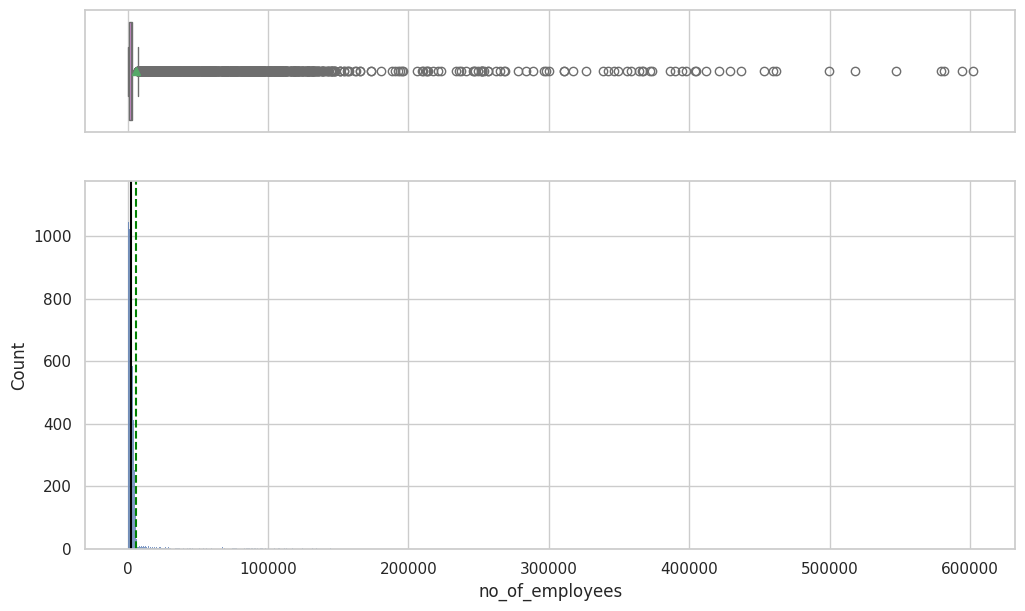

In [ ]:
# histogram and boxplot for the column `no_of_employees`
histogram_boxplot(df, "no_of_employees")

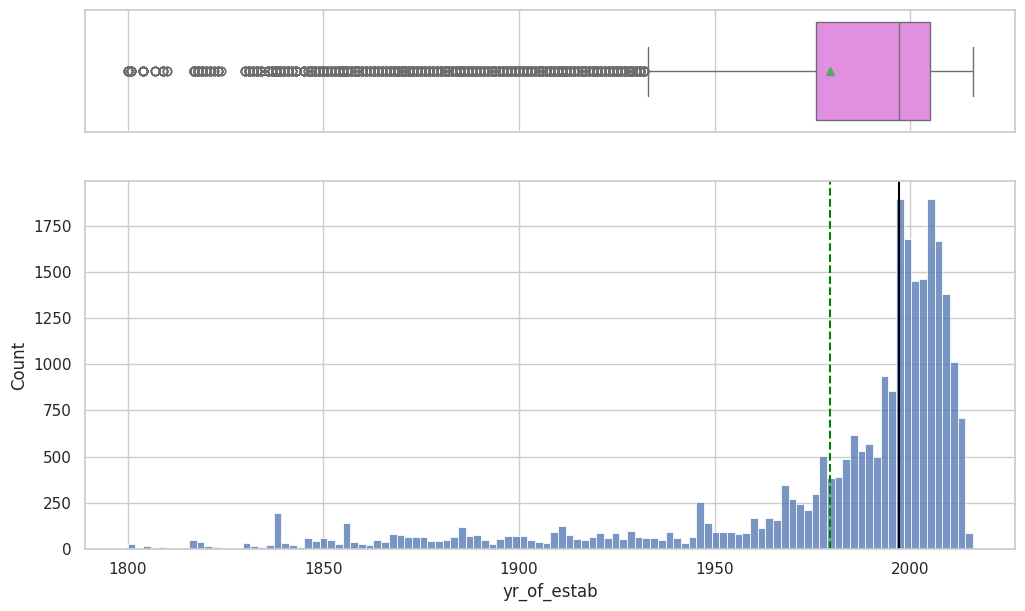

In [ ]:
# histogram and boxplot for the column `yr_of_estab`
histogram_boxplot(df, "yr_of_estab")

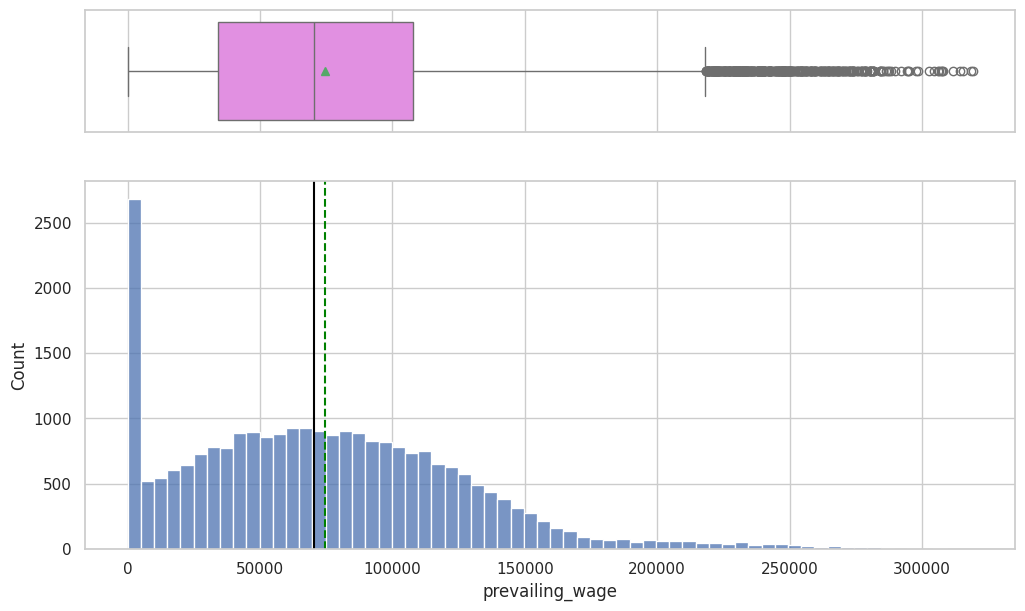

In [ ]:
# histogram and boxplot for the column `prevailing_wage`
histogram_boxplot(df, "prevailing_wage")

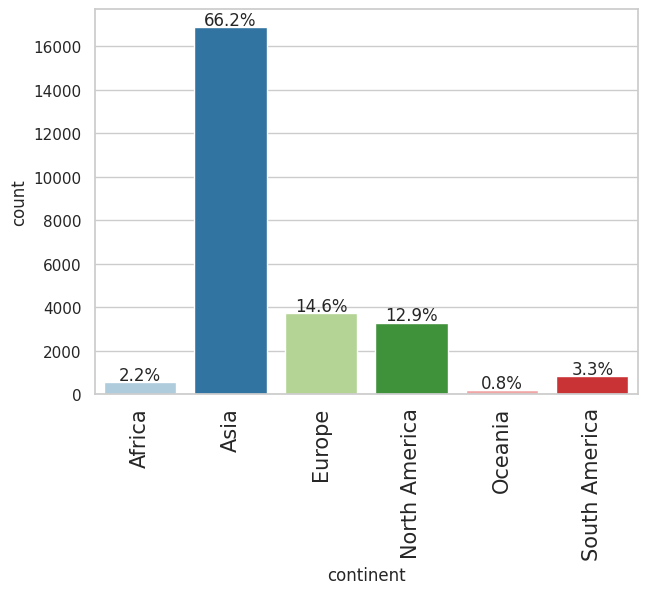

In [ ]:
# the distribution of `continent`
labeled_barplot(df, "continent", perc=True)

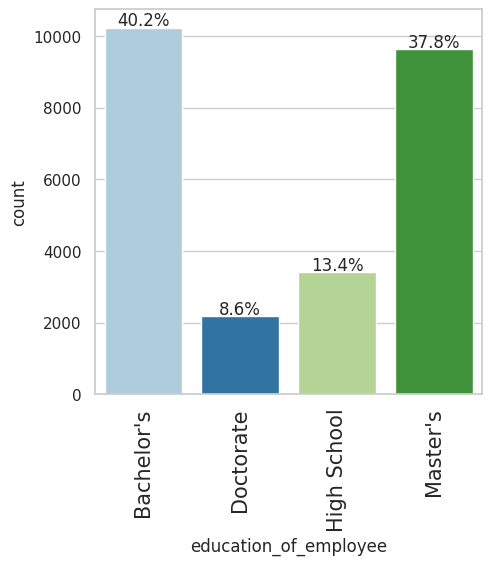

In [ ]:
#the distribution of `education_of_employee`
labeled_barplot(df, "education_of_employee", perc=True)

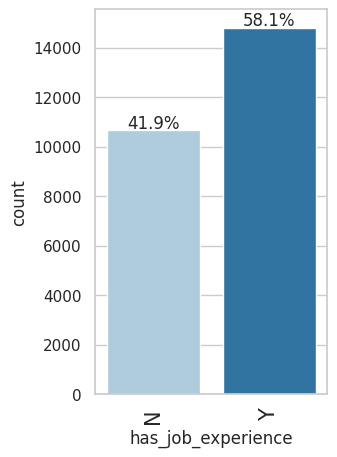

In [ ]:
# the distribution of `has_job_experience`
labeled_barplot(df, "has_job_experience", perc=True)

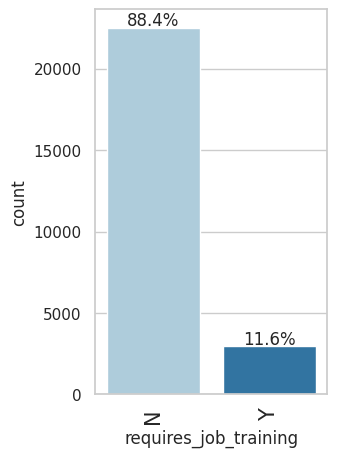

In [ ]:
#the distribution of `requires_job_training`
labeled_barplot(df, "requires_job_training", perc=True)

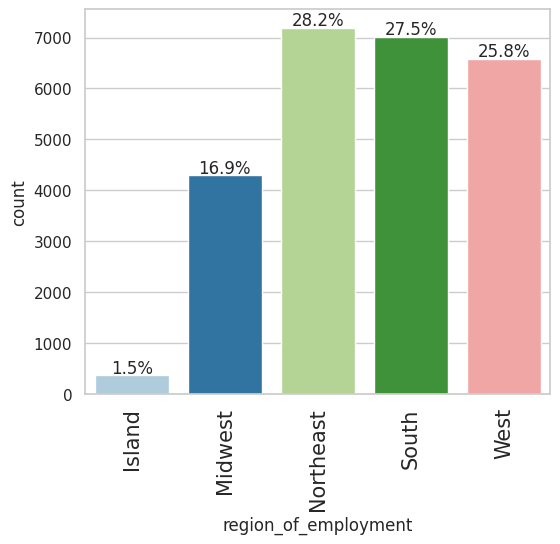

In [ ]:
#the distribution of `region_of_employment`
labeled_barplot(df, "region_of_employment", perc=True)

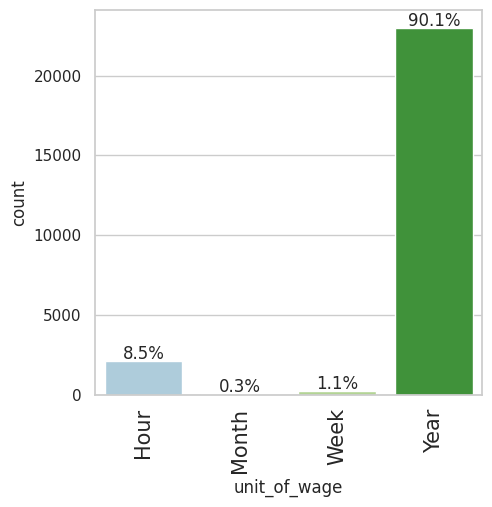

In [ ]:
#the distribution of `unit_of_wage`
labeled_barplot(df, "unit_of_wage", perc=True)

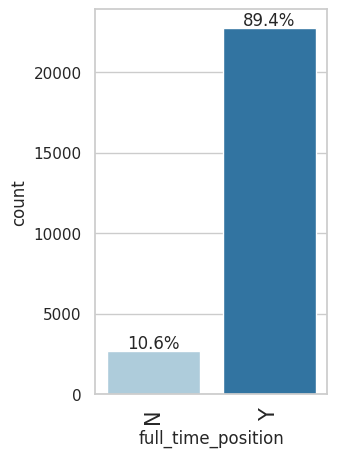

In [ ]:
#the distribution of `full_time_position`
labeled_barplot(df, "full_time_position", perc=True)

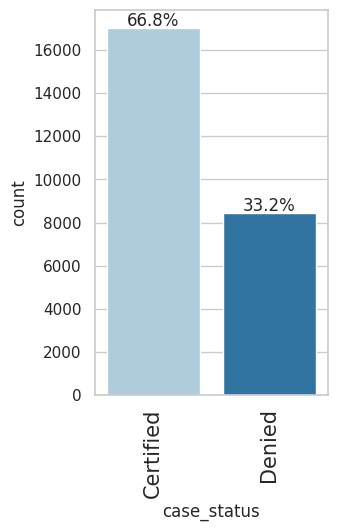

In [ ]:
#the distribution of `case_status`
labeled_barplot(df, "case_status", perc=True)

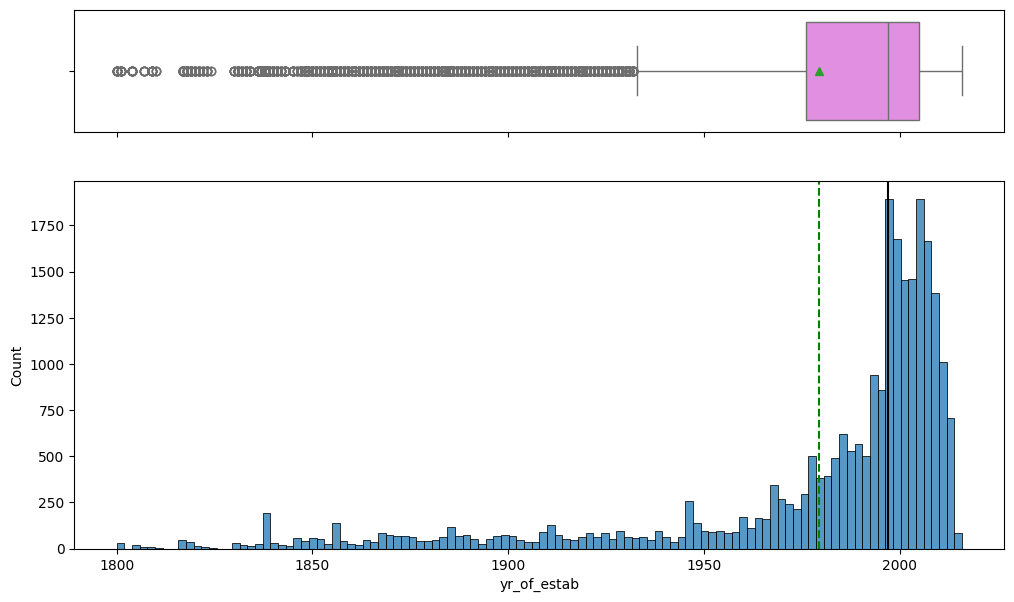

In [ ]:
histogram_boxplot(data, "yr_of_estab")

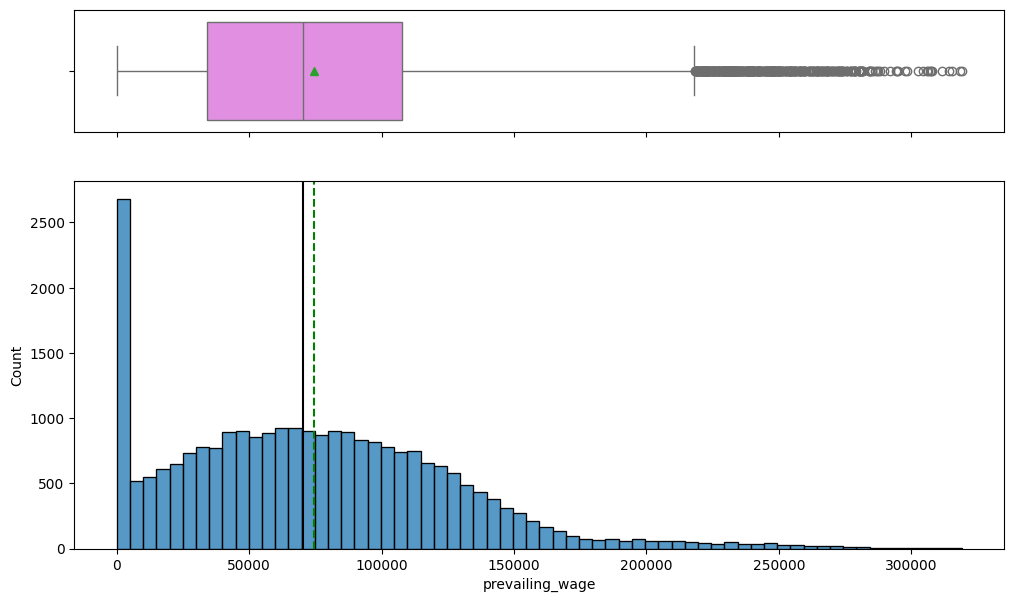

In [ ]:
histogram_boxplot(data, "prevailing_wage")

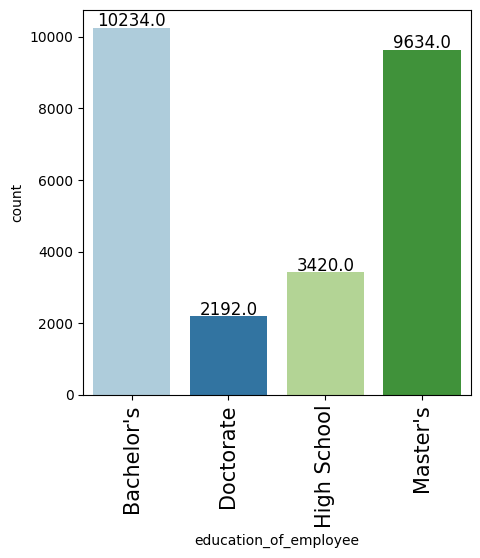

In [ ]:
# Observations on Customer_age
labeled_barplot(data, "education_of_employee")

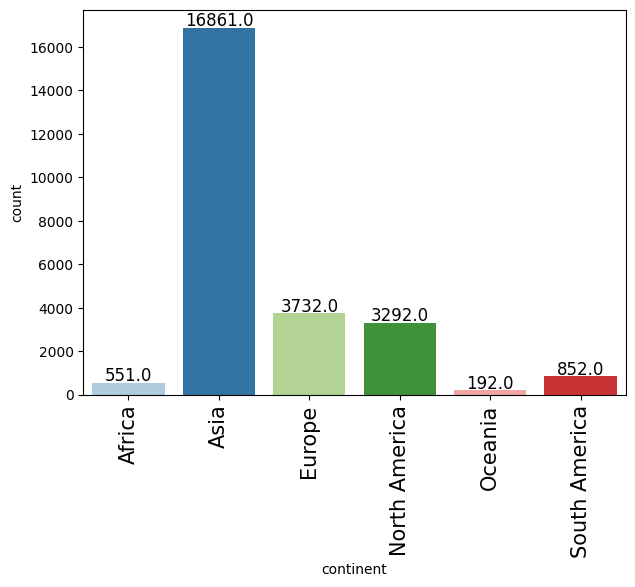

In [ ]:
labeled_barplot(data, "continent")

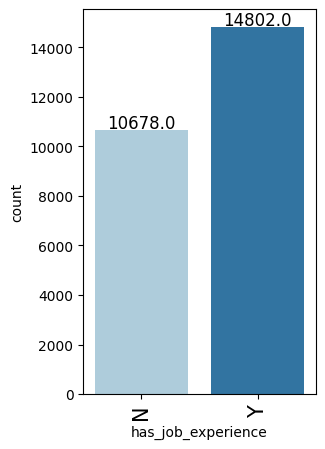

In [ ]:
labeled_barplot(data, "has_job_experience")

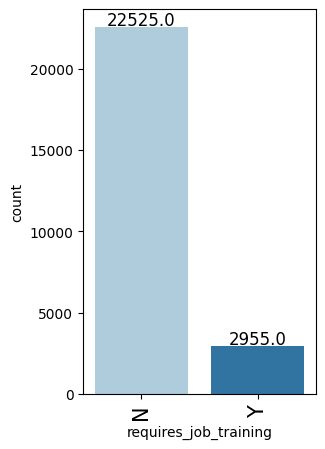

In [ ]:
labeled_barplot(data, "requires_job_training")

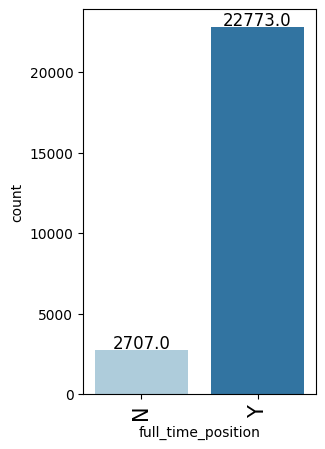

In [ ]:
labeled_barplot(data, "full_time_position")

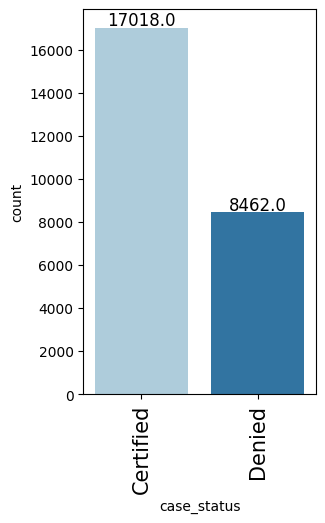

In [ ]:
labeled_barplot(data, "case_status")

### Bivariate Analysis

case_status    Certified  Denied    All
continent                              
All                17018    8462  25480
Asia               11012    5849  16861
North America       2037    1255   3292
Europe              2957     775   3732
South America        493     359    852
Africa               397     154    551
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


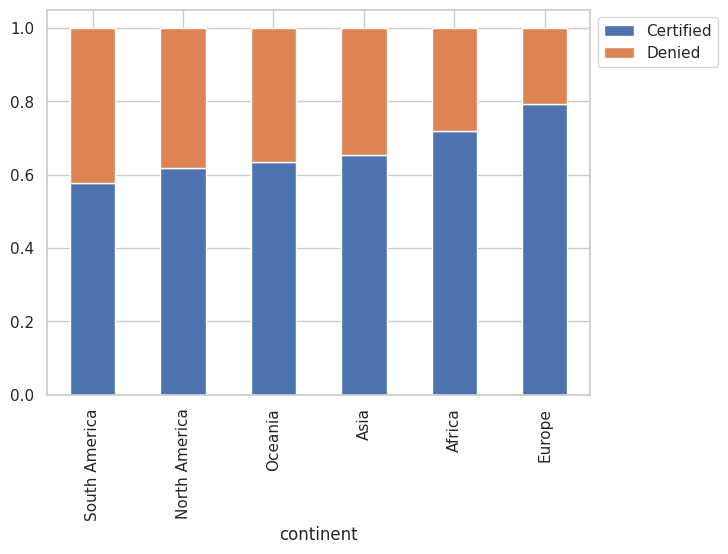

In [ ]:
stacked_barplot(df, "continent", "case_status")

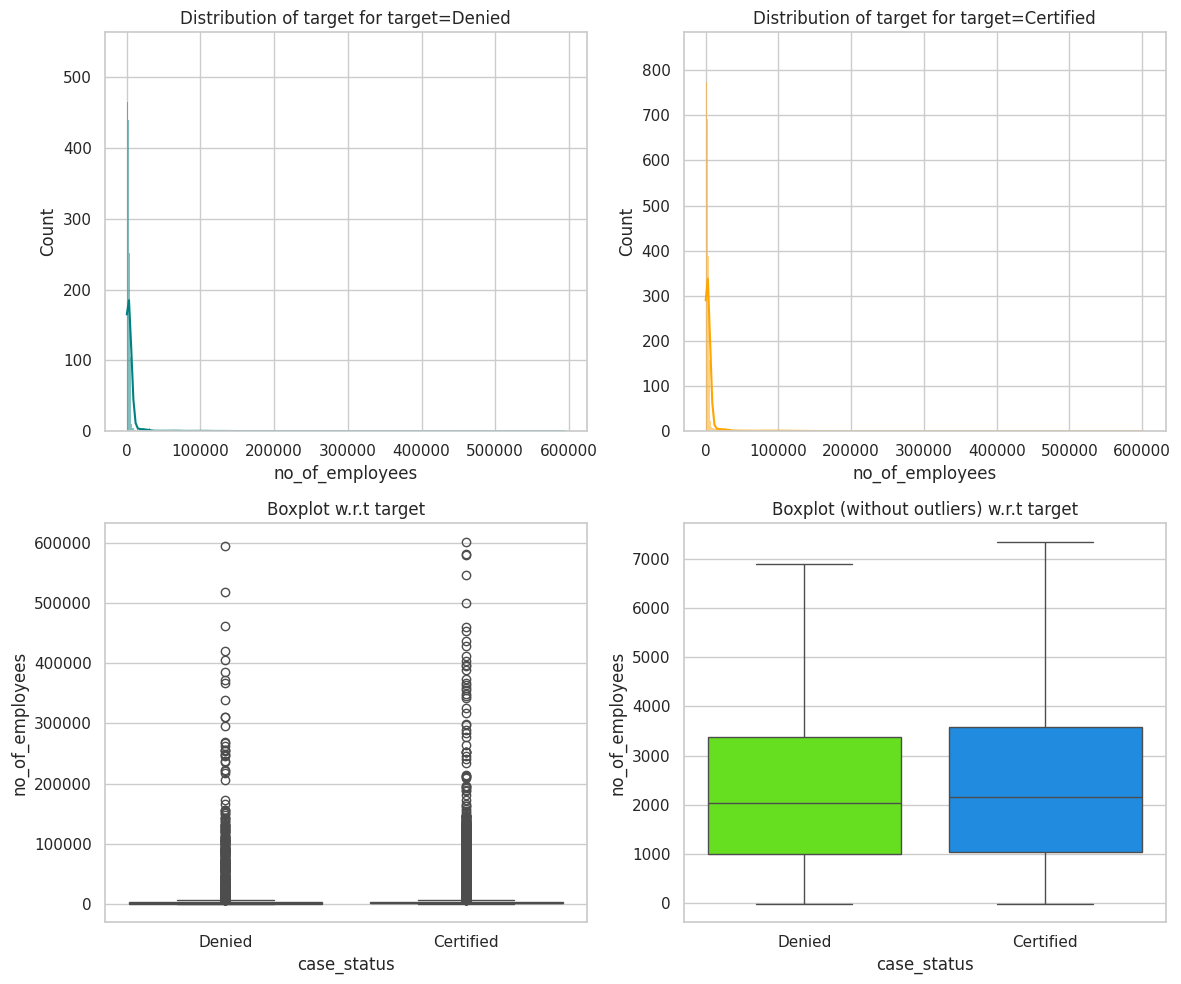

In [ ]:
distribution_plot_wrt_target(df, "no_of_employees", "case_status")

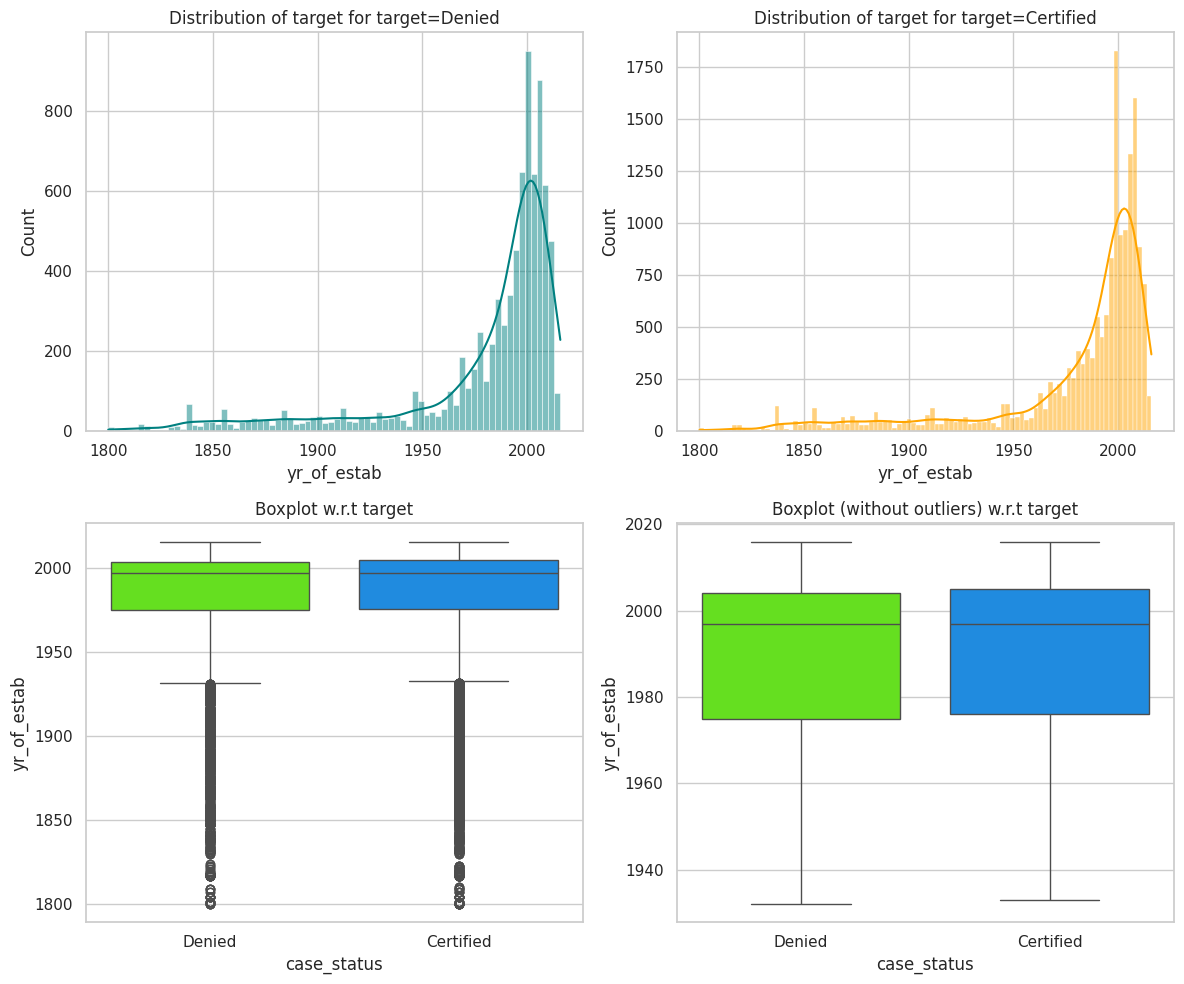

In [ ]:
distribution_plot_wrt_target(df, "yr_of_estab", "case_status")

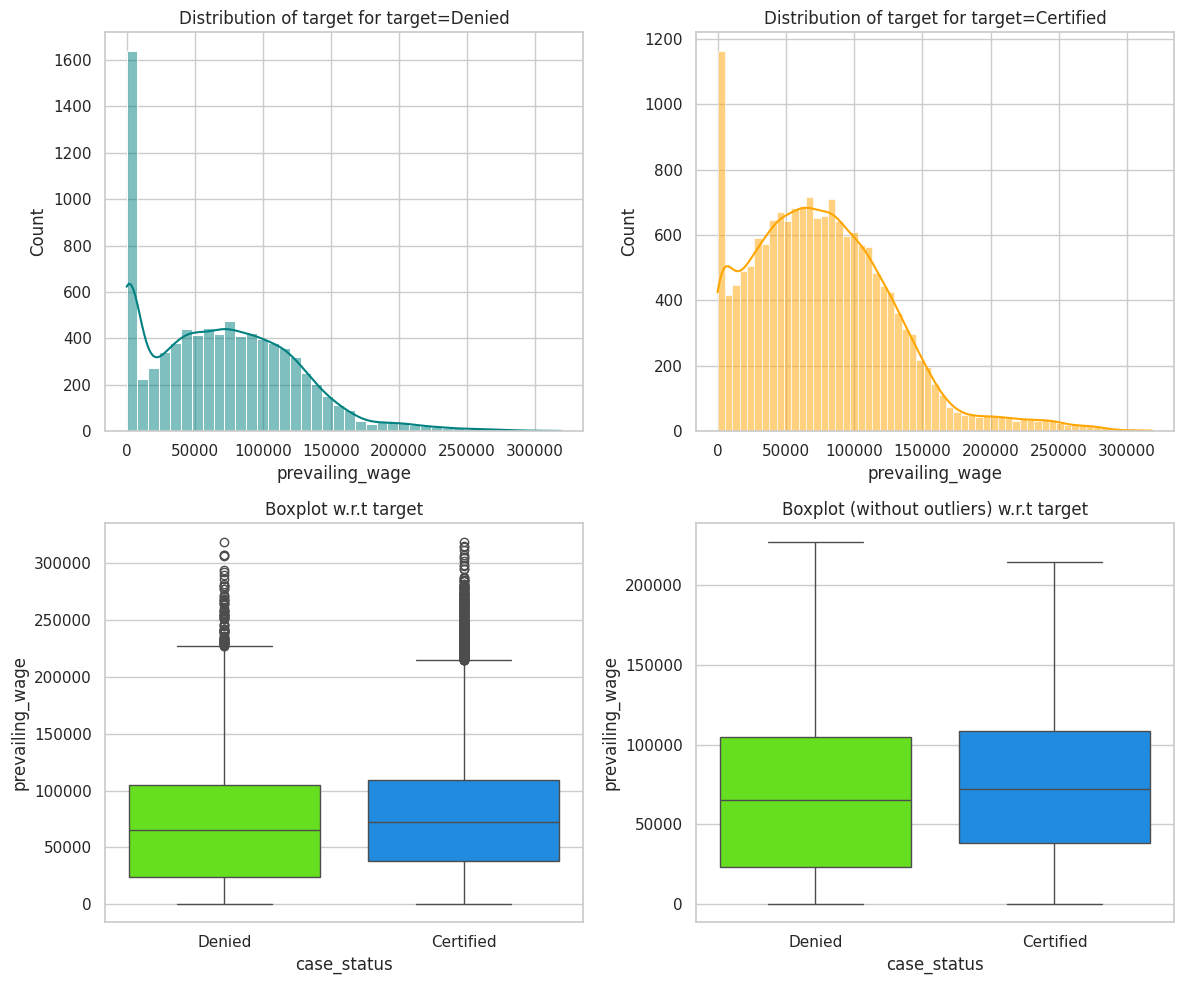

In [ ]:
distribution_plot_wrt_target(df, "prevailing_wage", "case_status")

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Bachelor's                  6367    3867  10234
High School                 1164    2256   3420
Master's                    7575    2059   9634
Doctorate                   1912     280   2192
------------------------------------------------------------------------------------------------------------------------


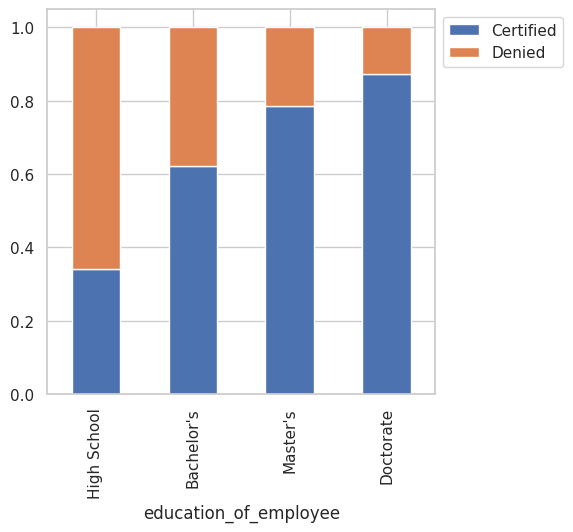

In [ ]:
stacked_barplot(df, "education_of_employee", "case_status")

case_status         Certified  Denied    All
has_job_experience                          
All                     17018    8462  25480
N                        5994    4684  10678
Y                       11024    3778  14802
------------------------------------------------------------------------------------------------------------------------


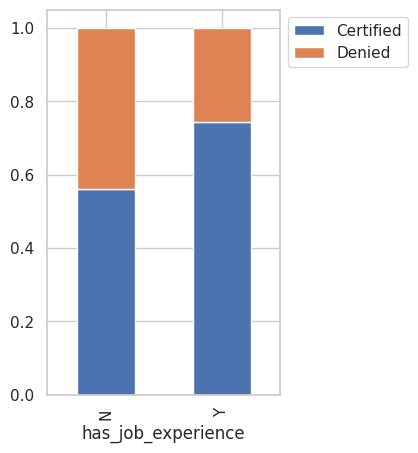

In [ ]:
stacked_barplot(df, "has_job_experience", "case_status")

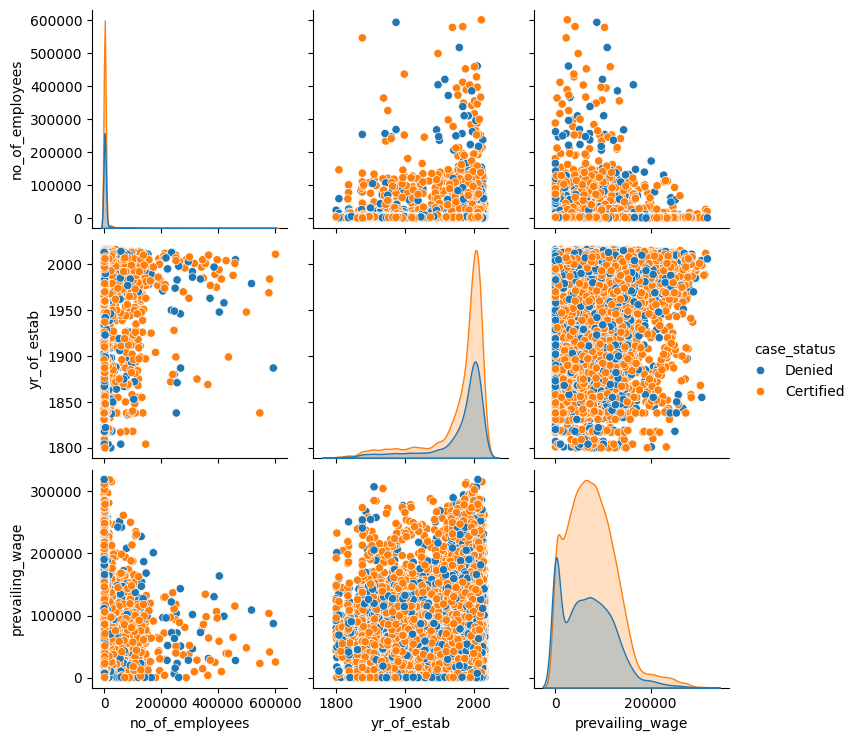

In [ ]:
sns.pairplot(data, hue="case_status")

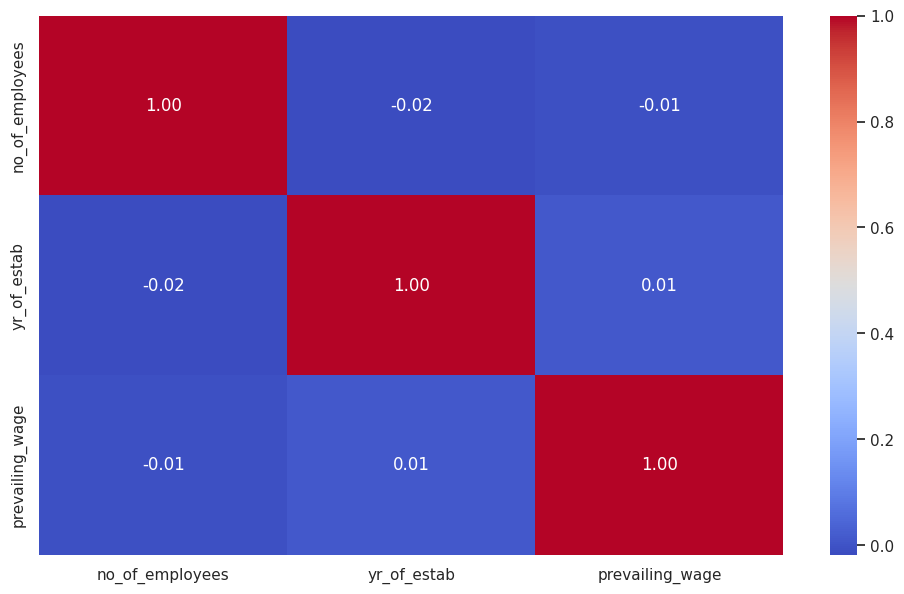

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 7))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap='coolwarm') # Changed cmap to 'coolwarm'
plt.show()

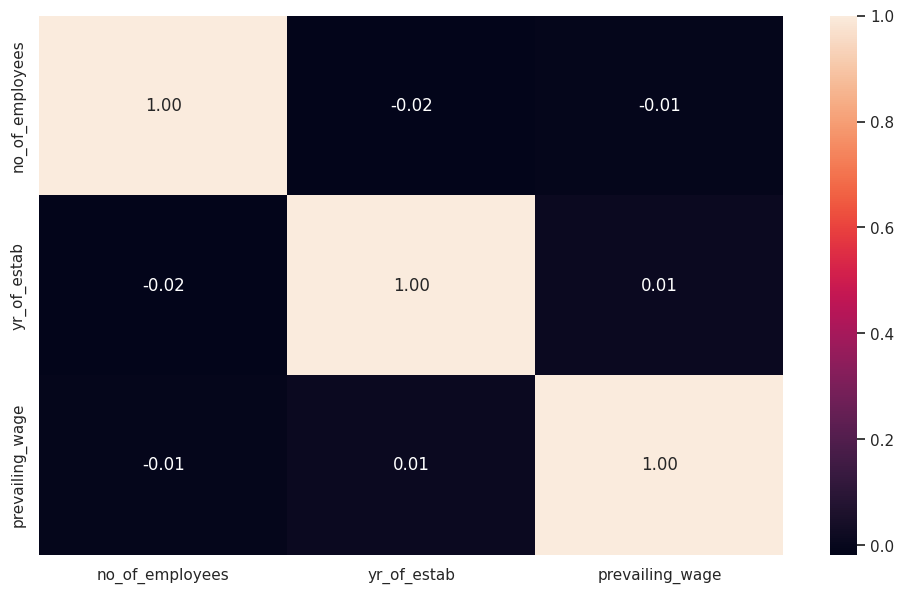

In [ ]:
# prompt: corelation matrix

import matplotlib.pyplot as plt
import numpy as np
# Let's look at the correlation matrix for numerical columns
plt.figure(figsize=(12, 7))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f")
plt.show()

<Axes: xlabel='case_status', ylabel='yr_of_estab'>

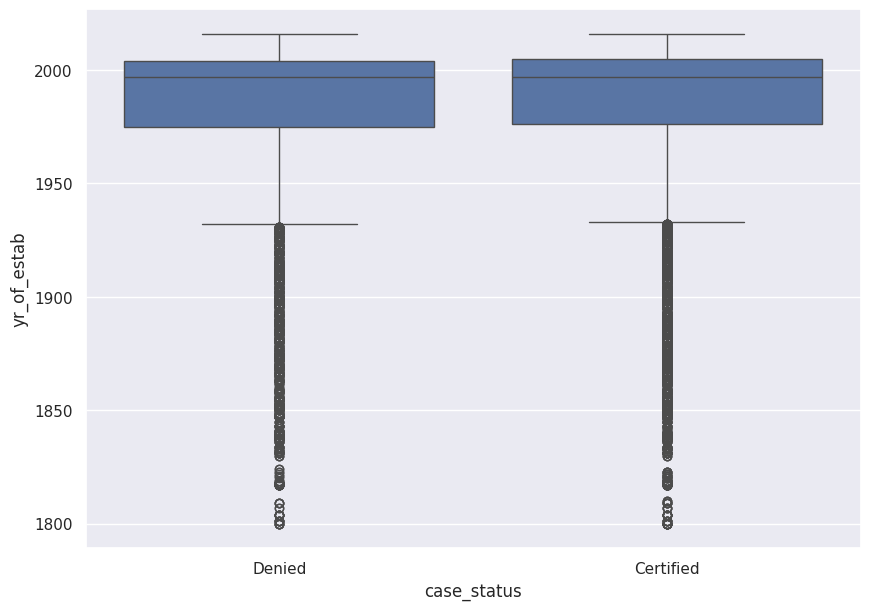

In [ ]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="case_status", y="yr_of_estab", data=data, orient="vertical")

case_status            Certified  Denied    All
education_of_employee                          
All                        17018    8462  25480
Bachelor's                  6367    3867  10234
High School                 1164    2256   3420
Master's                    7575    2059   9634
Doctorate                   1912     280   2192
------------------------------------------------------------------------------------------------------------------------


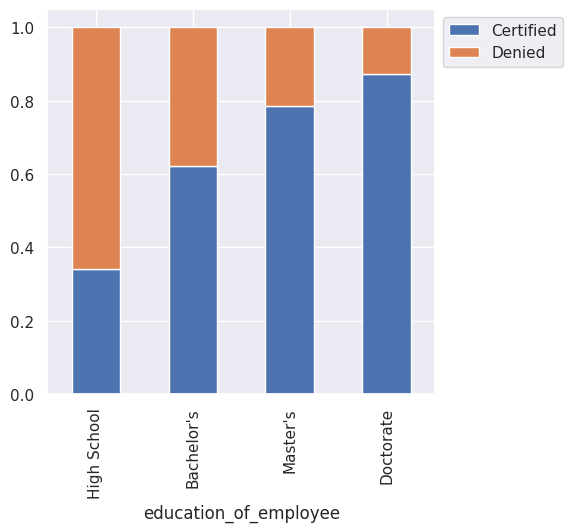

In [ ]:
stacked_barplot(data, "education_of_employee", "case_status")

case_status    Certified  Denied    All
continent                              
All                17018    8462  25480
Asia               11012    5849  16861
North America       2037    1255   3292
Europe              2957     775   3732
South America        493     359    852
Africa               397     154    551
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


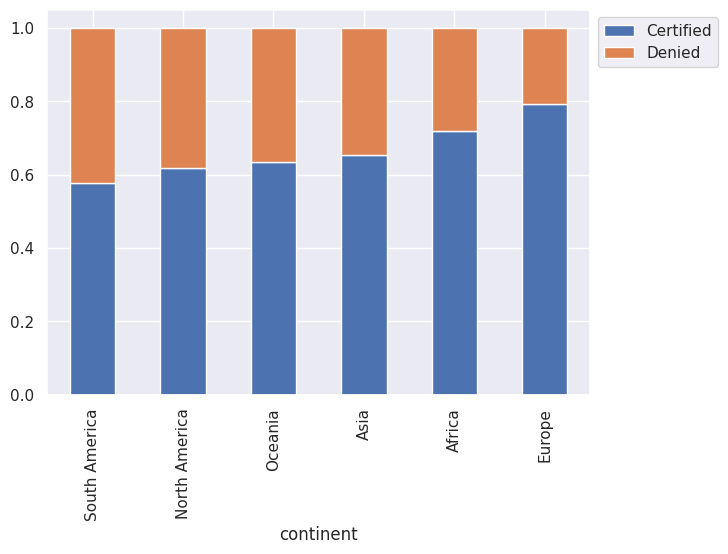

In [ ]:
stacked_barplot(data, "continent", "case_status")

case_status         Certified  Denied    All
has_job_experience                          
All                     17018    8462  25480
N                        5994    4684  10678
Y                       11024    3778  14802
------------------------------------------------------------------------------------------------------------------------


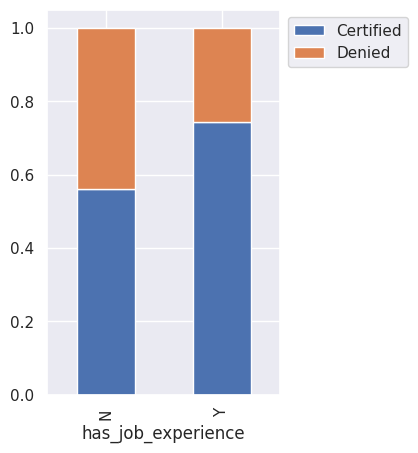

In [ ]:
stacked_barplot(data, "has_job_experience", "case_status")

case_status            Certified  Denied    All
requires_job_training                          
All                        17018    8462  25480
N                          15012    7513  22525
Y                           2006     949   2955
------------------------------------------------------------------------------------------------------------------------


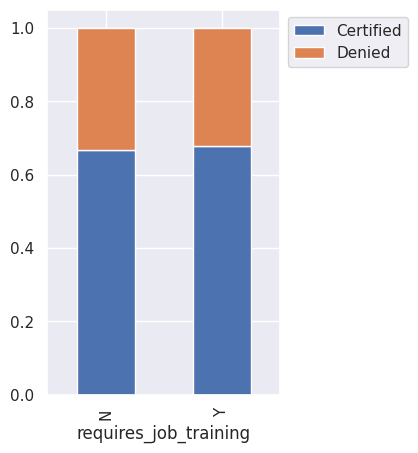

In [ ]:
stacked_barplot(data, "requires_job_training", "case_status")

In [ ]:
plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

ValueError: could not convert string to float: 'EZYV01'

<Figure size 1500x700 with 0 Axes>

## Feature Engineering

In [10]:
data1 = df.copy()

In [ ]:
data.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

In [ ]:
data.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.203,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.650,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.860,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.030,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.390,Year,Y,Certified


* we need to pass numerical values for each categorical column for imputation so we will label encode them

* Encoding 1 and 0 to 'Certified' and 'Denied' respectively, for analysis.

In [11]:
data1.drop(["case_id"], axis=1, inplace=True)

In [12]:
# we need to pass numerical values for each categorical column for imputation so we will label encode them
# Continent mapping
continent_map = {
    "Asia": 0,
    "Africa": 1,
    "Europe": 2,
    "North America": 3,
    "South America": 4,
    "Oceania": 5,
}
data1["continent"] = data1["continent"].map(continent_map)

# Education of employee
education_map = {
    "High School": 0,
    "Bachelor's": 1,
    "Master's": 2,
    "Doctorate": 3,
    "Other": 4
}
data1["education_of_employee"] = data1["education_of_employee"].map(education_map)

# Has job experience
experience_map = {"Y": 1, "N": 0}
data1["has_job_experience"] = data1["has_job_experience"].map(experience_map)

# Requires job training
training_map = {"Y": 1, "N": 0}
data1["requires_job_training"] = data1["requires_job_training"].map(training_map)

# Region of employment
region_map = {
    "West": 0,
    "Northeast": 1,
    "South": 2,
    "Midwest": 3,
    "Other": 4
}
data1["region_of_employment"] = data1["region_of_employment"].map(region_map)

# Unit of wage
wage_unit_map = {
    "Hour": 0,
    "Week": 1,
    "Month": 2,
    "Year": 3,
    "Bi-Weekly": 4
}
data1["unit_of_wage"] = data1["unit_of_wage"].map(wage_unit_map)

# Full-time position
full_time_map = {"Y": 1, "N": 0}
data1["full_time_position"] = data1["full_time_position"].map(full_time_map)


In [13]:
data1.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,0,0,0,0,14513,2007,0.000,592.203,0,1,Denied
1,0,2,1,0,2412,2002,1.000,83425.650,3,1,Certified
2,0,1,0,1,44444,2008,0.000,122996.860,3,1,Denied
3,0,1,0,0,98,1897,0.000,83434.030,3,1,Denied
4,1,2,1,0,1082,2005,2.000,149907.390,3,1,Certified


In [14]:
data1.shape

(25480, 11)

In [ ]:
df.isnull().sum()

,0
case_id,0
continent,0
education_of_employee,0
has_job_experience,0
requires_job_training,0
no_of_employees,0
yr_of_estab,0
region_of_employment,0
prevailing_wage,0
unit_of_wage,0


## Data Preparation for Modeling

In [15]:
X = data1.drop(["case_status"], axis=1)
y = data1["case_status"].apply(lambda x: 1 if x == "Certified" else 0)

In [16]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(15288, 10) (5096, 10) (5096, 10)


In [17]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 15288
Number of rows in validation data = 5096
Number of rows in test data = 5096


## **Reverse encoding**

In [18]:
## Function to inverse the encoding
def inverse_mapping(x, y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype("category")
    X_val[y] = np.round(X_val[y]).map(inv_dict).astype("category")
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype("category")

In [19]:
inverse_mapping(continent_map, "continent")
inverse_mapping(education_map, "education_of_employee")
inverse_mapping(experience_map, "has_job_experience")
inverse_mapping(training_map, "requires_job_training")
inverse_mapping(region_map , "region_of_employment")
inverse_mapping(wage_unit_map , "unit_of_wage")
inverse_mapping(full_time_map , "full_time_position")


In [20]:
cols = X_train.select_dtypes(include=["object", "category"])
for i in cols.columns:
    print(X_train[i].value_counts())
    print("*" * 30)

continent
Asia             10085
Europe            2285
North America     1944
South America      528
Africa             333
Oceania            113
Name: count, dtype: int64
******************************
education_of_employee
Bachelor's     6141
Master's       5792
High School    2045
Doctorate      1310
Name: count, dtype: int64
******************************
has_job_experience
Y    8845
N    6443
Name: count, dtype: int64
******************************
requires_job_training
N    13477
Y     1811
Name: count, dtype: int64
******************************
region_of_employment
Northeast    4312
South        4248
West         3920
Midwest      2576
Name: count, dtype: int64
******************************
unit_of_wage
Year     13786
Hour      1286
Week       156
Month       60
Name: count, dtype: int64
******************************
full_time_position
Y    13678
N     1610
Name: count, dtype: int64
******************************


In [21]:
cols = X_val.select_dtypes(include=["object", "category"])
for i in cols.columns:
    print(X_val[i].value_counts())
    print("*" * 30)

continent
Asia             3395
Europe            713
North America     655
South America     173
Africa            121
Oceania            39
Name: count, dtype: int64
******************************
education_of_employee
Bachelor's     2033
Master's       1886
High School     694
Doctorate       483
Name: count, dtype: int64
******************************
has_job_experience
Y    2963
N    2133
Name: count, dtype: int64
******************************
requires_job_training
N    4501
Y     595
Name: count, dtype: int64
******************************
region_of_employment
Northeast    1430
South        1389
West         1352
Midwest       855
Name: count, dtype: int64
******************************
unit_of_wage
Year     4576
Hour      452
Week       57
Month      11
Name: count, dtype: int64
******************************
full_time_position
Y    4552
N     544
Name: count, dtype: int64
******************************


In [ ]:
cols = X_test.select_dtypes(include=["object", "category"])
for i in cols.columns:
    print(X_test[i].value_counts())
    print("*" * 30)

continent
Asia             3381
Europe            734
North America     693
South America     151
Africa             97
Oceania            40
Name: count, dtype: int64
******************************
education_of_employee
Bachelor's     2060
Master's       1956
High School     681
Doctorate       399
Name: count, dtype: int64
******************************
has_job_experience
Y    2994
N    2102
Name: count, dtype: int64
******************************
requires_job_training
N    4547
Y     549
Name: count, dtype: int64
******************************
region_of_employment
Northeast    1453
South        1380
West         1314
Midwest       876
Name: count, dtype: int64
******************************
unit_of_wage
Year     4600
Hour      419
Week       59
Month      18
Name: count, dtype: int64
******************************
full_time_position
Y    4543
N     553
Name: count, dtype: int64
******************************


### Creating Dummy Variables

In [22]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_val = pd.get_dummies(data=X_val, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)
print(X_train.shape, X_val.shape, X_test.shape)

(15288, 20) (5096, 20) (5096, 20)


# Model Building

## Model evaluation criterion

In [23]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [24]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Initial Model Building

### Model Building - Original Data

In [25]:
from sklearn.metrics import precision_score

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'), random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))

print("\nTraining Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = precision_score(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))

print("\nValidation Performance:\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores_val = precision_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))



Training Performance:

Bagging: 0.9891069676153091
Random forest: 1.0
GBM: 0.7838827838827839
Adaboost: 0.7624936900555275
Xgboost: 0.8553704360155973
dtree: 1.0

Validation Performance:

Bagging: 0.7743990732696207
Random forest: 0.771619812583668
GBM: 0.7841537246643854
Adaboost: 0.7666581567526168
Xgboost: 0.7662986330178759
dtree: 0.7426814988290398


In [26]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_train = precision_score(y_train, model.predict(X_train))
    scores_val = precision_score(y_val, model.predict(X_val))
    difference1 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference1))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9891, Validation Score: 0.7744, Difference: 0.2147
Random forest: Training Score: 1.0000, Validation Score: 0.7716, Difference: 0.2284
GBM: Training Score: 0.7839, Validation Score: 0.7842, Difference: -0.0003
Adaboost: Training Score: 0.7625, Validation Score: 0.7667, Difference: -0.0042
Xgboost: Training Score: 0.8554, Validation Score: 0.7663, Difference: 0.0891
dtree: Training Score: 1.0000, Validation Score: 0.7427, Difference: 0.2573


**Observations:**
Best performer overall:
- GBM has the best performance followed by AdaBoost model as per the validation performance

Excellent model. Generalizes perfectly. Validation > Train is a good sign.

### Model Building - Oversampled Data

In [27]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 10210
Before Oversampling, counts of label 'No': 5078 

After Oversampling, counts of label 'Yes': 10210
After Oversampling, counts of label 'No': 10210 

After Oversampling, the shape of train_X: (20420, 20)
After Oversampling, the shape of train_y: (20420,) 



In [28]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'), random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))

print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = precision_score(y_train_over, model.predict(X_train_over))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = precision_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

Bagging: 0.9923739724670694
Random forest: 0.9999020663989815
GBM: 0.7554645998432465
Adaboost: 0.7464311859443631
Xgboost: 0.8300595502621989
dtree: 1.0

Validation Performance:

Bagging: 0.7790553138595401
Random forest: 0.7764505119453925
GBM: 0.7910817506193228
Adaboost: 0.797472075249853
Xgboost: 0.7757212847033206
dtree: 0.7530139103554868


In [29]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores_train = precision_score(y_train_over, model.predict(X_train_over))
    scores_val = precision_score(y_val, model.predict(X_val))
    difference2 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference2))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9924, Validation Score: 0.7791, Difference: 0.2133
Random forest: Training Score: 0.9999, Validation Score: 0.7765, Difference: 0.2235
GBM: Training Score: 0.7555, Validation Score: 0.7911, Difference: -0.0356
Adaboost: Training Score: 0.7464, Validation Score: 0.7975, Difference: -0.0510
Xgboost: Training Score: 0.8301, Validation Score: 0.7757, Difference: 0.0543
dtree: Training Score: 1.0000, Validation Score: 0.7530, Difference: 0.2470


- GBM has the best performance on validation followed by Adaboost


### Model Building - Undersampled Data

In [30]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [31]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 10210
Before Under Sampling, counts of label 'No': 5078 

After Under Sampling, counts of label 'Yes': 5078
After Under Sampling, counts of label 'No': 5078 

After Under Sampling, the shape of train_X: (10156, 20)
After Under Sampling, the shape of train_y: (10156,) 



In [32]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'), random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))


print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = precision_score(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = precision_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

Bagging: 0.991096721974909
Random forest: 1.0
GBM: 0.7058823529411765
Adaboost: 0.6848047381084582
Xgboost: 0.8619561031959954
dtree: 1.0

Validation Performance:

Bagging: 0.8298969072164949
Random forest: 0.8236344162799001
GBM: 0.828125
Adaboost: 0.8138842975206612
Xgboost: 0.8202797202797203
dtree: 0.7718023255813954


In [33]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores_train = precision_score(y_train_un, model.predict(X_train_un))
    scores_val = precision_score(y_val, model.predict(X_val))
    difference3 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference3))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9911, Validation Score: 0.8299, Difference: 0.1612
Random forest: Training Score: 1.0000, Validation Score: 0.8236, Difference: 0.1764
GBM: Training Score: 0.7059, Validation Score: 0.8281, Difference: -0.1222
Adaboost: Training Score: 0.6848, Validation Score: 0.8139, Difference: -0.1291
Xgboost: Training Score: 0.8620, Validation Score: 0.8203, Difference: 0.0417
dtree: Training Score: 1.0000, Validation Score: 0.7718, Difference: 0.2282


- Xgboost has the best performance followed by GBM model as per the validation performance

## Hyperparameter Tuning

### Tuning AdaBoostClassifier model with Original data

In [ ]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(10, 40, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.precision_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': np.int64(30), 'learning_rate': 1, 'estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.7770894167142715:
CPU times: user 2.41 s, sys: 230 ms, total: 2.64 s
Wall time: 1min 32s


In [ ]:
tuned_adb_org = AdaBoostClassifier(
    random_state=1,
    n_estimators=30,
    learning_rate=1,
    estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
)
tuned_adb_org.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=1),
                   learning_rate=1, n_estimators=30, random_state=1)

In [ ]:
# Checking model's performance on training set
adb_org_train = model_performance_classification_sklearn(tuned_adb_org, X_train, y_train)
adb_org_train

,Accuracy,Recall,Precision,F1
0,0.749,0.871,0.779,0.823


In [ ]:

# Checking model's performance on validation set
adb_org_val = model_performance_classification_sklearn(tuned_adb_org, X_val, y_val)
adb_org_val

,Accuracy,Recall,Precision,F1
0,0.744,0.864,0.778,0.818


In [ ]:
# Difference in metrics between training and validation
difference = adb_org_val - adb_org_train
print(difference)

   Accuracy  Recall  Precision     F1
0    -0.005  -0.007     -0.001 -0.004


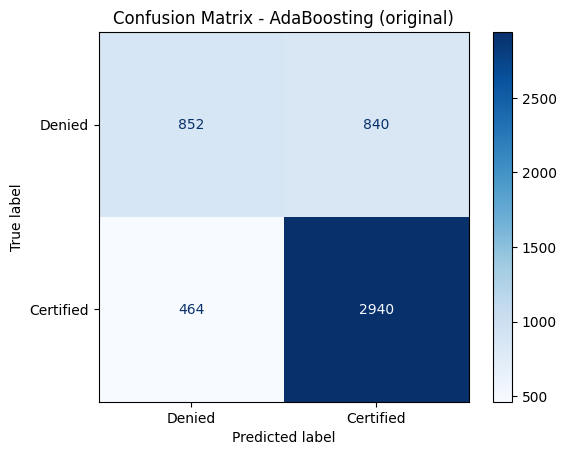

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on validation set
y_val_pred = tuned_adb_org.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
labels = ['Denied', 'Certified']  # Adjust if class names differ
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - AdaBoosting (original)")
plt.show()


### Tuning Gradient Boosting model with Oversampled data

In [ ]:
%%time

#defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.precision_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': np.int64(125), 'max_features': 0.7, 'learning_rate': 0.2, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.7586083730430333:
CPU times: user 6.75 s, sys: 720 ms, total: 7.47 s
Wall time: 5min 50s


In [ ]:
tuned_gbm2 = GradientBoostingClassifier(
    random_state=1,
    subsample=0.7,
    n_estimators=125,
    max_features=0.7,
    learning_rate=0.2,
    init=AdaBoostClassifier(random_state=1),
)
tuned_gbm2.fit(X_train_over, y_train_over)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.2, max_features=0.7,
                           n_estimators=125, random_state=1, subsample=0.7)

In [ ]:
# Checking model's performance on training set
gbm2_train = model_performance_classification_sklearn(tuned_gbm2, X_train_over, y_train_over)
gbm2_train

,Accuracy,Recall,Precision,F1
0,0.795,0.856,0.762,0.806


In [ ]:
# Checking model's performance on validation set
gbm2_val = model_performance_classification_sklearn(tuned_gbm2, X_val, y_val)
gbm2_val

,Accuracy,Recall,Precision,F1
0,0.741,0.843,0.784,0.813


In [ ]:
difference = gbm2_val - gbm2_train
print(difference)

   Accuracy  Recall  Precision    F1
0    -0.054  -0.013      0.022 0.006


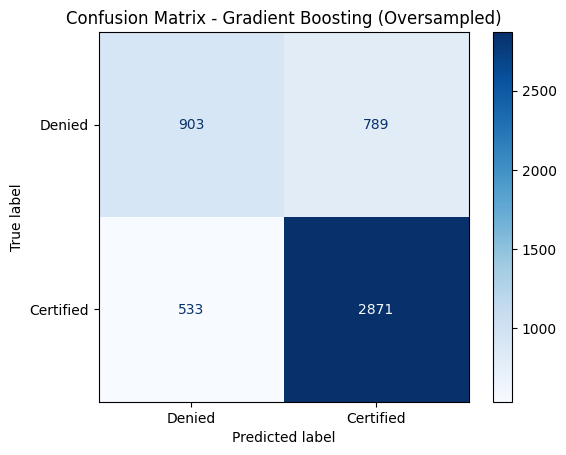

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on validation set
y_val_pred = tuned_gbm2.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
labels = ['Denied', 'Certified']  # Adjust if class names differ
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Gradient Boosting (Oversampled)")
plt.show()


### Tuning Gradient Boosting model with Undersampled data

In [ ]:
%%time

#defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.precision_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 1, 'n_estimators': np.int64(75), 'max_features': 0.7, 'learning_rate': 0.1, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.6973514411425088:
CPU times: user 3.69 s, sys: 363 ms, total: 4.06 s
Wall time: 3min 12s


In [34]:
tuned_un_gbm = GradientBoostingClassifier(
    random_state=1,
    subsample=1,
    n_estimators=75,
    max_features=0.7,
    learning_rate=0.1,
    init=AdaBoostClassifier(random_state=1),
)
tuned_un_gbm.fit(X_train_un, y_train_un)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.7, n_estimators=75, random_state=1,
                           subsample=1)

In [35]:
# Checking model's performance on training set
gbm_un_train = model_performance_classification_sklearn(tuned_un_gbm, X_train_un, y_train_un)
gbm_un_train

,Accuracy,Recall,Precision,F1
0,0.716,0.739,0.706,0.722


In [36]:
# Checking model's performance on validation set
gbm_un_val = model_performance_classification_sklearn(tuned_un_gbm, X_val, y_val)
gbm_un_val

,Accuracy,Recall,Precision,F1
0,0.719,0.727,0.831,0.775


In [37]:
difference = gbm_un_val - gbm_un_train
print(difference)

   Accuracy  Recall  Precision    F1
0     0.003  -0.012      0.125 0.053


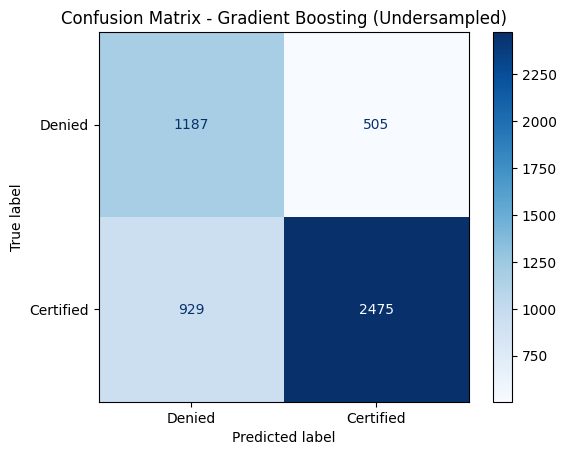

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on validation set
y_val_pred = tuned_un_gbm.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
labels = ['Denied', 'Certified']  # Adjust if class names differ
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Gradient Boosting (Undersampled)")
plt.show()


### Hyperparameter Tuning - XGBoost with Under sampled data

In [ ]:
%%time

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import numpy as np

# Define base XGBoost model
Model = XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss')

# Parameter grid
param_grid = {
    'n_estimators': np.arange(50, 200, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 5]  # helps with class imbalance
}

# Precision scorer
scorer = metrics.make_scorer(metrics.precision_score)

# Randomized Search
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=50,
    scoring=scorer,
    n_jobs=-1,
    cv=5,
    random_state=1,
    verbose=1
)

# Fit the model
randomized_cv.fit(X_train_un, y_train_un)

# Best result
print("Best parameters are {} with CV precision score={}".format(
    randomized_cv.best_params_, randomized_cv.best_score_))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters are {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': np.int64(100), 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 1.0} with CV precision score=0.6999058955443951
CPU times: user 2.78 s, sys: 144 ms, total: 2.92 s
Wall time: 44 s


In [ ]:
from xgboost import XGBClassifier

# Define the tuned XGBoost model
tuned_xgb_un = XGBClassifier(
    random_state=1,
    n_estimators=100,           # Adjust based on your best parameters
    learning_rate=0.01,
    max_depth=4,
    subsample=1.0,
    colsample_bytree=1.0,
    scale_pos_weight=1,         # Increase if the dataset is imbalanced
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
tuned_xgb_un.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [ ]:
# Checking model's performance on training set
xgp_un_train = model_performance_classification_sklearn(tuned_xgb_un, X_train_un, y_train_un)
xgp_un_train

,Accuracy,Recall,Precision,F1
0,0.694,0.670,0.704,0.687


In [ ]:
# Checking model's performance on validation set
xgp_un_val = model_performance_classification_sklearn(tuned_xgb_un, X_val, y_val)
xgp_un_val

,Accuracy,Recall,Precision,F1
0,0.686,0.663,0.832,0.738


In [ ]:
# Difference in metrics between training and validation
difference = xgp_un_val - xgp_un_train
print(difference)

   Accuracy  Recall  Precision    F1
0    -0.009  -0.007      0.128 0.051


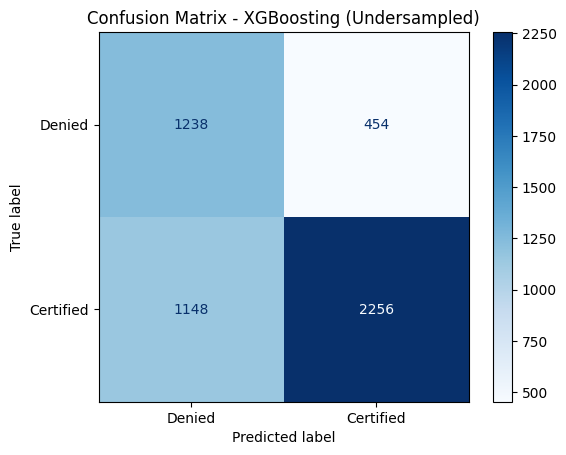

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on validation set
y_val_pred = tuned_xgb_un.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
labels = ['Denied', 'Certified']  # Adjust if class names differ
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoosting (Undersampled)")
plt.show()

## Model Comparison and Final Model Selection


In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        adb_org_train.T,
        gbm2_train.T,
        gbm_un_train.T,
        xgp_un_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "AdaBoost trained with Original data",
  "Gradient boosting trained with Oversampled data",
  "Gradient boosting trained with Undersampled data",
"XGboosting trained with Undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,AdaBoost trained with Original data,Gradient boosting trained with Oversampled data,Gradient boosting trained with Undersampled data,XGboosting trained with Undersampled data
Accuracy,0.749,0.795,0.716,0.694
Recall,0.871,0.856,0.739,0.670
Precision,0.779,0.762,0.706,0.704
F1,0.823,0.806,0.722,0.687


In [ ]:
# Validation performance comparison

models_train_comp_df = pd.concat(
    [ adb_org_val.T, gbm2_val.T, gbm_un_val.T, xgp_un_val.T], axis=1,
)
models_train_comp_df.columns = [
     "AdaBoost trained with Original data",
  "Gradient boosting trained with Oversampled data",
  "Gradient boosting trained with Undersampled data",
"XGboosting trained with Undersampled data",
]
print("Validation performance comparison:")
models_train_comp_df

Validation performance comparison:


,AdaBoost trained with Original data,Gradient boosting trained with Oversampled data,Gradient boosting trained with Undersampled data,XGboosting trained with Undersampled data
Accuracy,0.744,0.741,0.719,0.686
Recall,0.864,0.843,0.727,0.663
Precision,0.778,0.784,0.831,0.832
F1,0.818,0.813,0.775,0.738


In [ ]:
# prompt: plot a table comparing training and validation result

import pandas as pd
# Creating a table for model comparison
comparison_table = pd.DataFrame({
    'Model': [
        "AdaBoost (Original Data)",
        "Gradient Boosting (Oversampled Data)",
        "Gradient Boosting (Undersampled Data)",
        "XGBoost (Undersampled Data)"
    ],
    'Training Precision': [
        adb_org_train['Precision'].iloc[0],
        gbm2_train['Precision'].iloc[0],
        gbm_un_train['Precision'].iloc[0],
        xgp_un_train['Precision'].iloc[0],
    ],
    'Validation Precision': [
        adb_org_val['Precision'].iloc[0],
        gbm2_val['Precision'].iloc[0],
        gbm_un_val['Precision'].iloc[0],
        xgp_un_val['Precision'].iloc[0],
    ],
    'Training Recall': [
        adb_org_train['Recall'].iloc[0],
        gbm2_train['Recall'].iloc[0],
        gbm_un_train['Recall'].iloc[0],
        xgp_un_train['Recall'].iloc[0],
    ],
    'Validation Recall': [
        adb_org_val['Recall'].iloc[0],
        gbm2_val['Recall'].iloc[0],
        gbm_un_val['Recall'].iloc[0],
        xgp_un_val['Recall'].iloc[0],
    ],
    'Training F1-score': [
        adb_org_train['F1'].iloc[0],
        gbm2_train['F1'].iloc[0],
        gbm_un_train['F1'].iloc[0],
        xgp_un_train['F1'].iloc[0],
    ],
    'Validation F1-score': [
        adb_org_val['F1'].iloc[0],
        gbm2_val['F1'].iloc[0],
        gbm_un_val['F1'].iloc[0],
        xgp_un_val['F1'].iloc[0],
    ],
     'Training Accuracy': [
        adb_org_train['Accuracy'].iloc[0],
        gbm2_train['Accuracy'].iloc[0],
        gbm_un_train['Accuracy'].iloc[0],
        xgp_un_train['Accuracy'].iloc[0],
    ],
     'Validation Accuracy': [
        adb_org_val['Accuracy'].iloc[0],
        gbm2_val['Accuracy'].iloc[0],
        gbm_un_val['Accuracy'].iloc[0],
        xgp_un_val['Accuracy'].iloc[0],
    ],
})

# Setting the 'Model' column as the index
comparison_table = comparison_table.set_index('Model')

# Transposing the table for better readability
comparison_table_T = comparison_table.T

print("\nModel Performance Comparison (Training vs Validation):")
comparison_table_T


Model Performance Comparison (Training vs Validation):


Model,AdaBoost (Original Data),Gradient Boosting (Oversampled Data),Gradient Boosting (Undersampled Data),XGBoost (Undersampled Data)
Training Precision,0.779,0.762,0.706,0.704
Validation Precision,0.778,0.784,0.831,0.832
Training Recall,0.871,0.856,0.739,0.670
Validation Recall,0.864,0.843,0.727,0.663
Training F1-score,0.823,0.806,0.722,0.687
Validation F1-score,0.818,0.813,0.775,0.738
Training Accuracy,0.749,0.795,0.716,0.694
Validation Accuracy,0.744,0.741,0.719,0.686


**Best Model Based on Precision**

👉 Gradient Boosting trained with Undersampled data

Precision: 0.831 (Highest)

Accuracy: 0.719	 (Competitive)

F1 Score: 0.775	 (Balanced)

Recall: 0.663 (Still acceptable)

### Test performance

In [38]:
# Let's check the performance on test set
GB_test = model_performance_classification_sklearn(tuned_un_gbm, X_test, y_test)
GB_test

,Accuracy,Recall,Precision,F1
0,0.706,0.732,0.810,0.769


In [40]:
# a table with training validation and test result for tuned_un_gbm

import pandas as pd
# Creating a table for tuned_un_gbm results
tuned_un_gbm_results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Training (Undersampled)': [
        gbm_un_train['Precision'].iloc[0],
        gbm_un_train['Recall'].iloc[0],
        gbm_un_train['F1'].iloc[0],
        gbm_un_train['Accuracy'].iloc[0],
    ],
    'Validation': [
        gbm_un_val['Precision'].iloc[0],
        gbm_un_val['Recall'].iloc[0],
        gbm_un_val['F1'].iloc[0],
        gbm_un_val['Accuracy'].iloc[0],
    ],
    'Test': [
        GB_test['Precision'].iloc[0],
        GB_test['Recall'].iloc[0],
        GB_test['F1'].iloc[0],
        GB_test['Accuracy'].iloc[0],
    ]
})

# Setting the 'Metric' column as the index
tuned_un_gbm_results = tuned_un_gbm_results.set_index('Metric')

print("\nPerformance of Tuned Gradient Boosting Model (Undersampled Data):")
tuned_un_gbm_results



Performance of Tuned Gradient Boosting Model (Undersampled Data):


,Training (Undersampled),Validation,Test
Metric,,,
Precision,0.706,0.831,0.810
Recall,0.739,0.727,0.732
F1-score,0.722,0.775,0.769
Accuracy,0.716,0.719,0.706


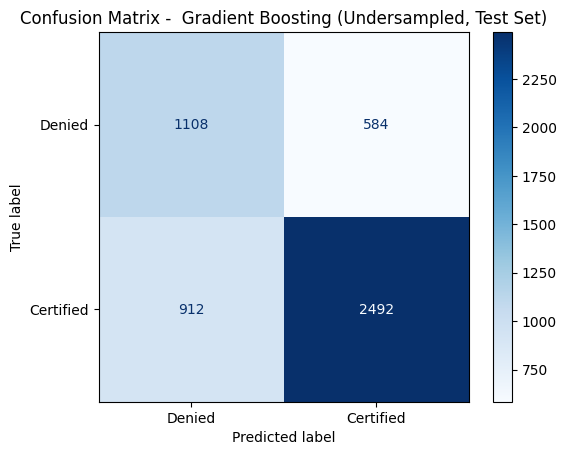

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
y_test_pred = tuned_un_gbm.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display confusion matrix
labels = ['Denied', 'Certified']  # Update if your labels differ
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix -  Gradient Boosting (Undersampled, Test Set)")
plt.show()

### Feature Importance

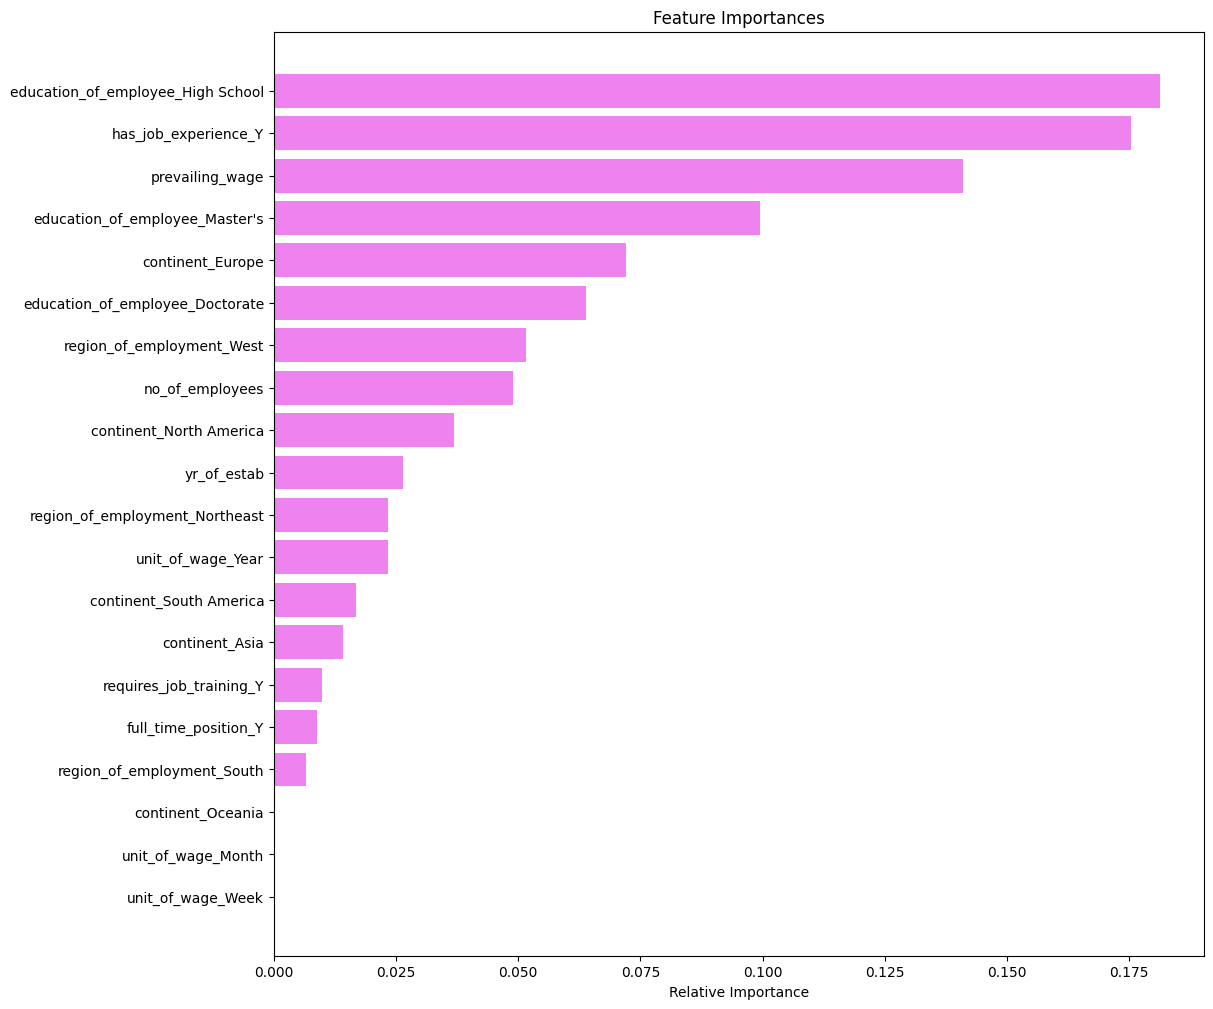

In [ ]:
feature_names = X_train.columns
importances = tuned_un_gbm.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Actionable Business Recommendations

**1. Prioritize Skilled & Experienced Profiles**

Focus recruitment on candidates with:

Prior relevant job experience (has_job_experience_Y)

Higher education (especially Master’s or Doctorate degrees)

Competitive wage offers (above market median)

This significantly increases the chances of visa certification.

**2. Wage Benchmarking**
Ensure wage offers align with or exceed the prevailing wage standards.

Visa denials are strongly linked to low wage offerings.

**3. Regional Policy Optimization**
Consider employer regions: West and Northeast have slightly better approval rates.

Evaluate labor market competitiveness by region to plan where to file applications.

**4. Target Sourcing Regions**
Candidates from Europe tend to have higher success.

Consider building stronger recruiting pipelines in favorable regions.

**5. Screen High-Risk Applications Early**
Use the model to flag high-risk applications (e.g., no experience, low wage, low education) before submission. This helps:

Reduce OFLC processing load

Focus effort on stronger applications

**6. Improve Applicant Qualification**
Encourage candidates to:

Gain relevant work experience

Upskill to achieve higher degrees

Participate in employer-sponsored training